In [70]:
# Common imports y set up de cada notebook

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow import keras
import os
import statsmodels.api as sm
from datetime import datetime
import time
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator

# Para imprimir objetos grandes
#np.set_printoptions(threshold = np.inf)

# Para mantener los resultados constantes al ejecutar
np.random.seed(42) # Un random.seed constante

# Para graficar figuras bonitas
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

mpl.rcParams["figure.figsize"] = (12,6.75)
mpl.rcParams["axes.grid"] = False


# Guardar/importar imágenes

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Guardar/importar datos
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
os.makedirs(DATA_PATH, exist_ok=True)

# Guardar datasets
DATASETS = os.path.join(PROJECT_ROOT_DIR, "datasets")
os.makedirs(DATASETS, exist_ok=True)

# Guardar modelos
MODELS = os.path.join(PROJECT_ROOT_DIR, "modelos")
os.makedirs(MODELS, exist_ok=True)

# Funciones 

In [104]:
def plot_real_vs_predicted(Y_real, Y_predicted, x_limits = (0,-1), savefig = False,
                           figname = "figure", formato = "png"):
    
    name = figname + "." + formato
    
    plt.figure(figsize = (14,7))
    
    y_limits = (Y_real.min(), Y_real.max())
    plt.ylim(y_limits)
    
    plt.plot(Y_real[x_limits[0]:x_limits[-1]], color = "black", linestyle = "-", linewidth=2.5, label="Real"), # color = "darkorange",
    plt.plot(Y_predicted[x_limits[0]:x_limits[-1]], "r.-", linewidth=2.3, label="Predicción")
    plt.legend(loc = 1, fontsize=20)   
    plt.xlabel("Tiempo (1 h)", fontsize=20) 
    plt.ylabel("Consumo (normalizado)", fontsize=20)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = formato, dpi = 200)
    
    plt.show() 
    
def plot_learning_curves(loss, val_loss):
    plt.figure(figsize = (12, 6.75))
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Entrenamiento")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validación")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("epoch")
    plt.ylabel("mse")
    plt.grid(True)
    plt.show() 

def plot_train_vs_val(train_errors, val_errors, batch_size, errores, figure_size = (12,6.75), savefig = False, 
                            figname = "figure", formato = "png"):
        
    name = figname + "." + formato
    
    plt.figure(figsize = figure_size)

    y_limits = (np.min([train_errors.min(), val_errors.min()]), np.max([train_errors.max(), val_errors.max()]))
    plt.ylim(y_limits)
       
   
    plt.title("Entrenamiento: "+("{:.4e}".format(errores[0]))+", Validación: "+("{:.4e}".format(errores[-1])),
              fontsize=18)
    plt.plot(train_errors,  "b.-", linewidth=2, label="Entrenamiento"), # color = "darkorange",
    plt.plot(val_errors, "r.-", linewidth=2, label="Validación")
    plt.legend(loc = 1, fontsize=20)   
    plt.xlabel("Tamaño del conjunto de entrenamiento / "+str(batch_size), fontsize=20) 
    plt.ylabel("mse", fontsize=20)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = formato, dpi = 200)
    
    plt.show() 
    
    
def ts_learning_curves(model, X_train, Y_train, X_val, Y_val, batch = 1):
    
    # Esta función ENTRENA un modelo de ML y muestra sus Learning curves.
        
    train_errors, val_errors = [], []
    print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
    
    start_time = time.time()
    
    iteraciones = Y_train.shape[0]
    
    for i in range(0, iteraciones, batch):
        
        index = i+1    
        if (index + 1) > iteraciones:
            break
            
        X_train_slice, Y_train_slice = X_train[:index], Y_train[:index]
        
        model.fit(X_train_slice, Y_train_slice)
            
        Y_train_slice_predicted = model.predict(X_train_slice)
        Y_val_predicted = model.predict(X_val)
        
        train_errors.append(mean_squared_error(Y_train_slice, Y_train_slice_predicted))
        val_errors.append(mean_squared_error(Y_val, Y_val_predicted))
        
        current_time = time.time()
    
        if i%100 == 0: # Notificación para ver cuánto tiempo de entrenamiento lleva, y cuánto queda.
            print("training: "+str(i)+" of "+str(iteraciones), "current time: "+str(current_time - start_time) + " s")

    execution_time = time.time() - start_time
    

        
    print("tiempo de ejecución: "+str(execution_time)+" s")
    
    history = pd.DataFrame()
    history["loss"] = train_errors
    history["val_loss"] = val_errors
    
    return history


def plot_hours(real, predicted, targets = 1, bloques = 12, savefig = False, name = "modelo"):
    
    Y_real = []
    Y_predicted = []
    
    a = 0
    for i in range(0, targets*bloques, bloques):
        
        Y_real.extend(real[i])
        Y_predicted.extend(predicted[i])
         
    plt.figure(figsize = (14, 7))
    plt.plot(Y_real, color = "black", linestyle = "-", linewidth=2.5, label="Real")
    plt.plot(Y_predicted,  "r.-", linewidth=2.3, label="Predicción")
    plt.legend(loc = 1, fontsize=20)    
    plt.xlabel("Tiempo (1 h)", fontsize=20) 
    plt.ylabel("Consumo (normalizado)", fontsize=20)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = "png", dpi = 200)
    
    plt.show() 
    

# Importo los datos

In [72]:
df_train = pd.read_csv(os.path.join(DATASETS, "df_train.csv"))
df_test = pd.read_csv(os.path.join(DATASETS, "df_test.csv"))

formato = '%Y-%m-%d %H'

df_train['Datetime'] = pd.to_datetime(df_train["Datetime"], format=formato, utc = True)
df_train = df_train.set_index(pd.DatetimeIndex(df_train['Datetime']))
df_train.drop(["Datetime"], axis = "columns", inplace = True)

df_test['Datetime'] = pd.to_datetime(df_test["Datetime"], format=formato, utc = True)
df_test = df_test.set_index(pd.DatetimeIndex(df_test['Datetime']))
df_test.drop(["Datetime"], axis = "columns", inplace = True)

useful_features = df_train.columns.to_list()
print(df_train.shape, df_train.columns, "\n")
print(df_test.shape, df_test.columns, "\n")
print(df_train.index.min(), df_train.index.max(), df_test.index.min(), df_test.index.max())

(28051, 38) Index(['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', 'Consumo_MW', 'y + 1', 'y + 2', 'y + 3', 'y + 4',
       'y + 5', 'y + 6', 'y + 7', 'y + 8', 'y + 9', 'y + 10', 'y + 11',
       'y + 12', 'y + 13', 'y + 14', 'y + 15', 'y + 16', 'y + 17', 'y + 18',
       'y + 19', 'y + 20', 'y + 21', 'y + 22', 'y + 23', 'y + 24'],
      dtype='object') 

(7013, 38) Index(['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', 'Consumo_MW', 'y + 1', 'y + 2', 'y + 3', 'y + 4',
       'y + 5', 'y + 6', 'y + 7', 'y + 8', 'y + 9', 'y + 10', 'y +

# Preparación de los datasets

In [73]:
# Selecciono las columnas para multi step forecasting.

df_train = df_train.iloc[:,:-12].dropna() #todas las columnas, de y + 1 a y + 12
df_test = df_test.iloc[:,:-12].dropna()
df_train.iloc[:,:]

# Selecciono las columnas

X_Y_train = df_train.to_numpy()
X_Y_test = df_test.to_numpy()
X_test = X_Y_test[:,:-12]
Y_test = X_Y_test[:,-12:]


# Hago la división en train y val

from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Hacer train_test_split con shuffle = False y random_state = cte sirve para dividir time series

X_train, X_val, Y_train, Y_val = train_test_split(X_Y_train[:,:-12], X_Y_train[:,-12:],
                                                  test_size = 0.25, random_state = 42, shuffle = False)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

# Escalo la data a un rango [0, 1]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_Y_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(Y_train)], axis = 1)
#X_Y_train = np.concatenate([X_train, np.expand_dims(Y_train, axis=1)], axis = 1)
X_Y_train = scaler.fit_transform(X_Y_train)

X_Y_val = pd.concat([pd.DataFrame(X_val), pd.DataFrame(Y_val)], axis = 1)
#X_Y_val = np.concatenate([X_val, np.expand_dims(Y_val, axis=1)], axis = 1)
X_Y_val = scaler.transform(X_Y_val)

X_Y_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(Y_test)], axis = 1)
#X_Y_test = np.concatenate([X_test, np.expand_dims(Y_test, axis=1)], axis = 1)
X_Y_test = scaler.transform(X_Y_test)


X_train = X_Y_train[:,:-12]
Y_train = X_Y_train[:,-12:]

X_val = X_Y_val[:,:-12]
Y_val = X_Y_val[:,-12:]

X_test = X_Y_test[:,:-12]
Y_test = X_Y_test[:,-12:]

print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

print(X_train[0], Y_train[0], X_val[0], Y_val[0]) # Compruebo que está estandarizdo

(21029, 14) (21029, 12) (7010, 14) (7010, 12) (7001, 14) (7001, 12)
[0.44065198 0.36477505 1.         0.19080256 0.54194047 0.00691683
 0.17962843 0.         1.         0.18833984 1.         0.74444444
 1.         0.31966571] [0.27600766 0.2042744  0.14124663 0.09676156 0.0811352  0.08570558
 0.10168016 0.08936189 0.1129973  0.1832071  0.23966223 0.26516932] [0.26966836 0.26538832 0.17391304 0.05460977 0.47941631 0.00760851
 0.2220782  0.         1.         0.18107932 0.         0.5
 0.72       0.32871942] [0.43309829 0.53434317 0.60329068 0.63950553 0.66727605 0.69478541
 0.69443719 0.64203012 0.60816575 0.60429181 0.60376948 0.58352921]


In [74]:
# Modelos de base & tabla de errores

# mi modelo de base va a ser naive forecasting. "El consumo de hoy es el mismo que el de ayer"

# función auxiliar

def baseline_model_2(samples, columnas, previous_sample=1): # cualquier instante anterior
    
    # columnas es una lista con los targets
    # Samples es un ndarray con los targets
    # previous_sample es la muestra anterior que queremos que se devuelva
    
    df = pd.DataFrame(data = samples, columns = columnas)
    #if previous_sample > len(columnas):
     #   return ("No hay instantes anteriores a t-"+str(previous_sample))
    
    for i in range(len(columnas)):
        df[columnas[i]+"_pred"] = df[columnas[i]].shift(previous_sample)
    
    return df.dropna()


# Creo la predicción del modelo naive en los tres sets

# train, val, test

columnas = df_train.iloc[:,-12:].columns.to_list()

naive_train = baseline_model_2(Y_train, columnas, previous_sample = 24)
naive_val = baseline_model_2(Y_val, columnas, previous_sample = 24)
naive_test = baseline_model_2(Y_test, columnas, previous_sample = 24)

# creo un dataframe para guardar los errores
from sklearn.metrics import mean_squared_error, r2_score

errores_df = pd.DataFrame()

naive_train_errors = list()
naive_val_errors = list()
naive_test_errors = list()

for i in range(len(naive_train.index)):
    actual = naive_train.iloc[i,:-12].to_numpy()
    predicted = naive_train.iloc[i,-12:].to_numpy()
    naive_train_errors.append(mean_squared_error(actual, predicted))
for i in range(len(naive_val.index)):
    actual = naive_val.iloc[i,:-12].to_numpy()
    predicted = naive_val.iloc[i,-12:].to_numpy()
    naive_val_errors.append(mean_squared_error(actual, predicted))
for i in range(len(naive_test.index)):
    actual = naive_test.iloc[i,:-12].to_numpy()
    predicted = naive_test.iloc[i,-12:].to_numpy()
    naive_test_errors.append(mean_squared_error(actual, predicted))

naive_train_errors = np.array(naive_train_errors)
naive_val_errors   = np.array(naive_val_errors)
naive_test_errors  = np.array(naive_test_errors)


In [78]:
RESULTADOS = pd.DataFrame() 


name = "naive_12h"

RESULTADOS.loc[name, "train 1 mse"]             = naive_train_errors.mean()
RESULTADOS.loc[name, "val mse"]                 = naive_val_errors.mean()
RESULTADOS.loc[name, "train 2 mse"]             = None
RESULTADOS.loc[name, "test mse"]                = naive_test_errors.mean()

RESULTADOS.loc[name, "test R^2"]                = 0

RESULTADOS.loc[name, "delta train 1 and val"]   = np.abs(RESULTADOS.loc[name, "val mse"] - RESULTADOS.loc[name, "train 1 mse"])
                                        
RESULTADOS.loc[name, "delta train 2 and test"]  = 0


RESULTADOS.loc[name, "training 1 time (s)"]             = 0
RESULTADOS.loc[name, "train 1 prediction time (s)"]     = 0
RESULTADOS.loc[name, "val prediction time (s)"]         = 0

RESULTADOS.loc[name, "training 2 time (s)"]             = 0
RESULTADOS.loc[name, "train 2 prediction time (s)"]     = 0
RESULTADOS.loc[name, "test prediction time (s)"]        = 0

RESULTADOS.loc[name, "# params"]                        = 0

RESULTADOS.loc[name, "Complexity"]                      = 0


pd.options.display.float_format = '{:.3e}'.format
#pd.options.display.float_format = '{:.7f}'.format
#pd.reset_option("all")
RESULTADOS.sort_values(by = ["val mse"])

,train 1 mse,val mse,train 2 mse,test mse,test R^2,delta train 1 and val,delta train 2 and test,training 1 time (s),train 1 prediction time (s),val prediction time (s),training 2 time (s),train 2 prediction time (s),test prediction time (s),# params,Complexity
naive_12h,2.395e-02,2.308e-02,nan,2.331e-02,0.000e+00,8.736e-04,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00


In [79]:
def calcular_datos_ML(modelo, train, val, test, resultados_df, name = "modelo",
                      n_params = np.nan, complexity = None):

    # train, val, test son tuplas del estilo: train =  (X_train, Y_train)
    # resultados es un dataframe
    ##########################################################################
    
    # Trabajo sólo en TRAIN + VAL
    
    # 1. Entreno los modelos en train
    train_1_start = time.time()
    modelo.fit(train[0], train[-1])
    train_1_time = time.time() - train_1_start
    
    # 2. Hago las predicciones en train
    train_1_predict_start = time.time()
    Y_train_1_predicted     = modelo.predict(train[0])
    train_1_predict_time  = time.time() - train_1_predict_start
    
    # 3. Hago las predicciones en val
    val_predict_start = time.time()
    Y_val_predicted   = modelo.predict(val[0])
    val_predict_time  = time.time() - val_predict_start
    
    
    # Trabajo en el dataset ENTERO
    
    # 1. Concateno X_train y X_val para crear un nuevo X_train, e ídem con Y_train
    
    X_train = np.concatenate((train[0], val[0]), axis = 0)
    Y_train = np.concatenate((train[-1], val[-1]), axis = 0)
    
    # 2. Entreno los modelos en train total
    train_2_start = time.time()
    modelo.fit(X_train, Y_train)
    train_2_time  = time.time() - train_2_start
    
    # 3. Hago las predicciones en train
    train_2_predict_start = time.time()
    Y_train_2_predicted   = modelo.predict(X_train)
    train_2_predict_time  = time.time() - train_2_predict_start
    
    # 4. Hago las predicciones en test
    test_predict_start = time.time()
    Y_test_predicted   = modelo.predict(test[0])
    test_predict_time  = time.time() - test_predict_start
    
    
    # CÁLCULO DE ERRORES Y DURACIONES
    
    
    # MSE:
    resultados_df.loc[name, "train 1 mse"]             = mean_squared_error(train[-1], Y_train_1_predicted)
    resultados_df.loc[name, "val mse"]                 = mean_squared_error(val[-1], Y_val_predicted)
    resultados_df.loc[name, "train 2 mse"]             = mean_squared_error(Y_train, Y_train_2_predicted)
    resultados_df.loc[name, "test mse"]                = mean_squared_error(test[-1], Y_test_predicted)
    
    # R^2:
    resultados_df.loc[name, "test R^2"]                = r2_score(test[-1], Y_test_predicted)
    
    # Deltas
    resultados_df.loc[name, "delta train 1 and val"]   = np.abs(resultados_df.loc[name, "train 1 mse"] - 
                                                               resultados_df.loc[name, "val mse"])
    resultados_df.loc[name, "delta train 2 and test"]  = np.abs(resultados_df.loc[name, "train 2 mse"] - 
                                                               resultados_df.loc[name, "test mse"])
    # Duraciones (s)
    
    resultados_df.loc[name, "training 1 time (s)"]             = train_1_time
    resultados_df.loc[name, "train 1 prediction time (s)"]     = train_1_predict_time
    resultados_df.loc[name, "val prediction time (s)"]         = val_predict_time
    
    resultados_df.loc[name, "training 2 time (s)"]             = train_2_time
    resultados_df.loc[name, "train 2 prediction time (s)"]     = train_2_predict_time
    resultados_df.loc[name, "test prediction time (s)"]        = test_predict_time
    
    # Parámeros
    
    resultados_df.loc[name, "# params"]                        = n_params
    
    # Complejidad
    
    resultados_df.loc[name, "Complexity"]                      = complexity
    

    resultados_df.sort_values(by = ["test mse"])

    return resultados_df, Y_train_1_predicted, Y_val_predicted, Y_train_2_predicted, Y_test_predicted

# MLR

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

mlr = MultiOutputRegressor(LinearRegression(n_jobs = -1), n_jobs=-1)

RESULTADOS, Y_train_1_mlr, Y_val_mlr, Y_train_2_mlr, Y_test_mlr = calcular_datos_ML(mlr, (X_train, Y_train),
                                                                                (X_val, Y_val), (X_test, Y_test),
                                                                                RESULTADOS, name = "mlr",
                                                                                n_params = 15*12)

## Decsion Tree Ensembles 

In [81]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor


rfr = RandomForestRegressor(n_estimators = 50, max_depth = 10, n_jobs = -1, random_state = 42)


RESULTADOS, Y_train_1_rfr, Y_val_rfr, Y_train_2_rfr, Y_test_rfr = calcular_datos_ML(rfr, (X_train, Y_train),
                                                                                (X_val, Y_val), (X_test, Y_test),
                                                                                RESULTADOS, name = "rfr",
                                                                                n_params = None,
                                                                                complexity = "(10, 50)")

In [83]:
RESULTADOS.sort_values(by = ["test mse"])

,train 1 mse,val mse,train 2 mse,test mse,test R^2,delta train 1 and val,delta train 2 and test,training 1 time (s),train 1 prediction time (s),val prediction time (s),training 2 time (s),train 2 prediction time (s),test prediction time (s),# params,Complexity
rfr,4.358e-03,6.804e-03,4.662e-03,6.375e-03,8.353e-01,2.446e-03,1.713e-03,1.044e+00,1.084e-01,1.076e-01,1.458e+00,1.086e-01,1.080e-01,nan,"(10, 50)"
mlr,1.875e-02,1.857e-02,1.863e-02,1.820e-02,5.298e-01,1.710e-04,4.335e-04,1.764e+00,6.984e-01,3.868e-02,2.050e-01,1.335e-01,4.007e-02,1.800e+02,NaN
naive_12h,2.395e-02,2.308e-02,nan,2.331e-02,0.000e+00,8.736e-04,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00


# Redes Neuronales

## Preparo los datos

In [33]:
df_train = pd.read_csv(os.path.join(DATASETS, "df_train.csv"))
df_test = pd.read_csv(os.path.join(DATASETS, "df_test.csv"))

formato = '%Y-%m-%d %H'

df_train['Datetime'] = pd.to_datetime(df_train["Datetime"], format=formato, utc = True)
df_train = df_train.set_index(pd.DatetimeIndex(df_train['Datetime']))
df_train.drop(["Datetime"], axis = "columns", inplace = True)

df_test['Datetime'] = pd.to_datetime(df_test["Datetime"], format=formato, utc = True)
df_test = df_test.set_index(pd.DatetimeIndex(df_test['Datetime']))
df_test.drop(["Datetime"], axis = "columns", inplace = True)

useful_features = df_train.columns.to_list()
print(df_train.shape, df_train.columns, "\n")
print(df_test.shape, df_test.columns, "\n")
print(df_train.index.min(), df_train.index.max(), df_test.index.min(), df_test.index.max())

# Selecciono las columnas para multi step forecasting

df_train = df_train.iloc[:,:-12].dropna() #todas las columnas, de y + 1 a y + 12
df_test = df_test.iloc[:,:-12].dropna()
df_train.iloc[:,:]

# Selecciono las columnas

X_Y_train = df_train.to_numpy()
X_Y_test = df_test.to_numpy()
X_test = X_Y_test[:,:-12]
Y_test = X_Y_test[:,-12:]


# Hago la división en train y val

from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Hacer train_test_split con shuffle = False y random_state = cte sirve para dividir time series

X_train, X_val, Y_train, Y_val = train_test_split(X_Y_train[:,:-12], X_Y_train[:,-12:],
                                                  test_size = 0.25, random_state = 42, shuffle = False)

# Escalo la data a un rango [0, 1]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_Y_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(Y_train)], axis = 1)
#X_Y_train = np.concatenate([X_train, np.expand_dims(Y_train, axis=1)], axis = 1)
X_Y_train = scaler.fit_transform(X_Y_train)

X_Y_val = pd.concat([pd.DataFrame(X_val), pd.DataFrame(Y_val)], axis = 1)
#X_Y_val = np.concatenate([X_val, np.expand_dims(Y_val, axis=1)], axis = 1)
X_Y_val = scaler.transform(X_Y_val)

X_Y_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(Y_test)], axis = 1)
#X_Y_test = np.concatenate([X_test, np.expand_dims(Y_test, axis=1)], axis = 1)
X_Y_test = scaler.transform(X_Y_test)


# Lo convierto en un problema de ML

win_len = 24            # Intento predecir el consumo durante las próximas 24 h, con 24 h de antelación
tamaño_del_batch = 64
number_of_features = 14
horizonte = 12
sep = 1

X_train_val = np.concatenate((X_Y_train[:,:-12], X_Y_val[:,:-12]), axis = 0)
Y_train_val = np.concatenate((X_Y_train[:,-12:], X_Y_val[:,-12:]), axis = 0)

# series

train_ts_generator = TimeseriesGenerator(X_Y_train[:,:-12], X_Y_train[:,-12:], length = win_len, sampling_rate = 1,
                                         batch_size = tamaño_del_batch, stride = sep)

val_ts_generator = TimeseriesGenerator(X_Y_val[:,:-12], X_Y_val[:,-12:], length = win_len, sampling_rate = 1,
                                       batch_size = tamaño_del_batch, stride = sep)

train_and_val_ts_generator = TimeseriesGenerator(X_train_val, Y_train_val, length = win_len, sampling_rate = 1,
                                       batch_size = tamaño_del_batch, stride = 1)

test_ts_generator = TimeseriesGenerator(X_Y_test[:,:-12], X_Y_test[:,-12:], length = win_len, sampling_rate = 1,
                                         batch_size = tamaño_del_batch, stride = sep)


# length es el tamaño de la ventana
# sampling_rate es cada cuánto consideramos un dato (1 para datos continuos)
# stride es la separación entre una muestra de train y la siguiente 


print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
print(train_ts_generator[0][0].shape, train_ts_generator[0][1].shape)

(28051, 38) Index(['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', 'Consumo_MW', 'y + 1', 'y + 2', 'y + 3', 'y + 4',
       'y + 5', 'y + 6', 'y + 7', 'y + 8', 'y + 9', 'y + 10', 'y + 11',
       'y + 12', 'y + 13', 'y + 14', 'y + 15', 'y + 16', 'y + 17', 'y + 18',
       'y + 19', 'y + 20', 'y + 21', 'y + 22', 'y + 23', 'y + 24'],
      dtype='object') 

(7013, 38) Index(['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', 'Consumo_MW', 'y + 1', 'y + 2', 'y + 3', 'y + 4',
       'y + 5', 'y + 6', 'y + 7', 'y + 8', 'y + 9', 'y + 10', 'y +

In [34]:
resultados = pd.DataFrame()

In [35]:
from keras.models import load_model
from keras.utils.layer_utils import count_params

In [37]:
np.random.seed(42)
tf.random.set_seed(42)

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(24, input_shape = [win_len, number_of_features],
                           return_sequences = True),
    keras.layers.SimpleRNN(24, input_shape = [win_len, number_of_features]),
    keras.layers.Dense(horizonte)                                                      
])

checkpoint_rnn = keras.callbacks.ModelCheckpoint("rnn_multistep_final.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience = 10)

rnn.compile(loss = "mse", optimizer = "adam") # metrics = ["mse"])
                    

modelo = rnn
name = "rnn"

# 1. Entreno los modelos en train
train_1_start = time.time()
rnn.fit(train_ts_generator, epochs = 50, validation_data = val_ts_generator, shuffle = False, 
       callbacks = [early_stopping, checkpoint_rnn])
train_1_time = time.time() - train_1_start

# 2. Hago las predicciones en train
train_1_predict_start = time.time()
Y_train_1_predicted     = rnn.predict(train_ts_generator).flatten()
train_1_predict_time  = time.time() - train_1_predict_start

# 3. Hago las predicciones en val
val_predict_start = time.time()
Y_val_predicted   = rnn.predict(val_ts_generator).flatten()
val_predict_time  = time.time() - val_predict_start


# Trabajo en el dataset ENTERO, uso train_and_val_ts_generator

# 2. Entreno los modelos en train total
train_2_start = time.time()
rnn.fit(train_and_val_ts_generator, epochs = 50, validation_data = test_ts_generator, shuffle = False,
       callbacks = [early_stopping, checkpoint_rnn])
train_2_time  = time.time() - train_2_start

# 3. Hago las predicciones en train
train_2_predict_start = time.time()
Y_train_2_predicted   = rnn.predict(train_and_val_ts_generator).flatten()
train_2_predict_time  = time.time() - train_2_predict_start

# 4. Hago las predicciones en test
test_predict_start = time.time()
Y_test_predicted   = rnn.predict(test_ts_generator).flatten()
test_predict_time  = time.time() - test_predict_start


# CÁLCULO DE ERRORES Y DURACIONES

modelo = rnn

# MSE:
resultados.loc[name, "train 1 mse"]             = modelo.evaluate(train_ts_generator)
resultados.loc[name, "val mse"]                 = modelo.evaluate(val_ts_generator)
resultados.loc[name, "train 2 mse"]             = modelo.evaluate(train_and_val_ts_generator)
resultados.loc[name, "test mse"]                = modelo.evaluate(test_ts_generator)

# R^2:
#resultados_df.loc[name, "test R^2"]                = r2_score(, Y_test_predicted)

# Deltas
resultados.loc[name, "delta train 1 and val"]   = np.abs(resultados.loc[name, "train 1 mse"] - 
                                                           resultados.loc[name, "val mse"])
resultados.loc[name, "delta train 2 and test"]  = np.abs(resultados.loc[name, "train 2 mse"] - 
                                                           resultados.loc[name, "test mse"])
# Duraciones (s)

resultados.loc[name, "training 1 time (s)"]             = train_1_time
resultados.loc[name, "train 1 prediction time (s)"]     = train_1_predict_time
resultados.loc[name, "val prediction time (s)"]         = val_predict_time

resultados.loc[name, "training 2 time (s)"]             = train_2_time
resultados.loc[name, "train 2 prediction time (s)"]     = train_2_predict_time
resultados.loc[name, "test prediction time (s)"]        = test_predict_time

# Parámeros

resultados.loc[name, "# params"]                        = count_params(modelo.trainable_weights)

# Complejidad

resultados.loc[name, "Complexity"]                      = None


resultados.sort_values(by = ["test mse"])

Epoch 1/50
329/329 [==============================] - 4s 14ms/step - loss: 0.0477 - val_loss: 0.0367
Epoch 2/50
329/329 [==============================] - 4s 13ms/step - loss: 0.0270 - val_loss: 0.0230
Epoch 3/50
329/329 [==============================] - 4s 13ms/step - loss: 0.0195 - val_loss: 0.0170
Epoch 4/50
329/329 [==============================] - 4s 13ms/step - loss: 0.0159 - val_loss: 0.0146
Epoch 5/50
329/329 [==============================] - 4s 13ms/step - loss: 0.0142 - val_loss: 0.0137
Epoch 6/50
329/329 [==============================] - 4s 13ms/step - loss: 0.0132 - val_loss: 0.0131
Epoch 7/50
329/329 [==============================] - 4s 13ms/step - loss: 0.0124 - val_loss: 0.0127
Epoch 8/50
329/329 [==============================] - 4s 13ms/step - loss: 0.0117 - val_loss: 0.0123
Epoch 9/50
329/329 [==============================] - 4s 13ms/step - loss: 0.0111 - val_loss: 0.0120
Epoch 10/50
329/329 [==============================] - 4s 13ms/step - loss: 0.0106 - val_lo

438/438 [==============================] - 5s 12ms/step - loss: 0.0061 - val_loss: 0.0080
Epoch 32/50
438/438 [==============================] - 5s 12ms/step - loss: 0.0060 - val_loss: 0.0079
Epoch 33/50
438/438 [==============================] - 5s 12ms/step - loss: 0.0060 - val_loss: 0.0079
Epoch 34/50
438/438 [==============================] - 5s 12ms/step - loss: 0.0060 - val_loss: 0.0079
Epoch 35/50
438/438 [==============================] - 5s 12ms/step - loss: 0.0060 - val_loss: 0.0079
Epoch 36/50
438/438 [==============================] - 5s 12ms/step - loss: 0.0060 - val_loss: 0.0079
Epoch 37/50
438/438 [==============================] - 5s 12ms/step - loss: 0.0060 - val_loss: 0.0079
Epoch 38/50
438/438 [==============================] - 5s 12ms/step - loss: 0.0060 - val_loss: 0.0079
Epoch 39/50
438/438 [==============================] - 5s 12ms/step - loss: 0.0059 - val_loss: 0.0079
Epoch 40/50
438/438 [==============================] - 5s 12ms/step - loss: 0.0059 - val_loss:

,train 1 mse,val mse,train 2 mse,test mse,delta train 1 and val,delta train 2 and test,training 1 time (s),train 1 prediction time (s),val prediction time (s),training 2 time (s),train 2 prediction time (s),test prediction time (s),# params,Complexity
rnn,7.219e-03,6.902e-03,7.137e-03,7.631e-03,3.168e-04,4.937e-04,2.093e+02,1.795e+00,5.364e-01,2.663e+02,2.003e+00,5.350e-01,2.412e+03,nan


In [38]:
np.random.seed(42)
tf.random.set_seed(42)

lstm = keras.models.Sequential([
        keras.layers.LSTM(48, input_shape=[None, number_of_features], return_sequences = True),
        keras.layers.LSTM(24, input_shape=[None, number_of_features], return_sequences = True),
        keras.layers.LSTM(12, input_shape=[None, number_of_features], return_sequences = True),
        keras.layers.LSTM(12, input_shape=[None, number_of_features],),# return_sequences = True),
        #keras.layers.TimeDistributed(keras.layers.Dense(24), input_shape=[win_len, number_of_features])
        keras.layers.Dense(horizonte)                                                      
])

checkpoint_lstm = keras.callbacks.ModelCheckpoint("lstm_multistep_final.h5", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience = 5)

lstm.compile(loss = "mse", optimizer = "adam") # metrics = ["mse"])
                      

modelo = lstm
name = "lstm"

# 1. Entreno los modelos en train
train_1_start = time.time()
lstm.fit(train_ts_generator, epochs = 50, validation_data = val_ts_generator, shuffle = False,
        callbacks = [early_stopping, checkpoint_lstm])
train_1_time = time.time() - train_1_start

# 2. Hago las predicciones en train
train_1_predict_start = time.time()
Y_train_1_predicted     = lstm.predict(train_ts_generator).flatten()
train_1_predict_time  = time.time() - train_1_predict_start

# 3. Hago las predicciones en val
val_predict_start = time.time()
Y_val_predicted   = lstm.predict(val_ts_generator).flatten()
val_predict_time  = time.time() - val_predict_start


# Trabajo en el dataset ENTERO, uso train_and_val_ts_generator

# 2. Entreno los modelos en train total
train_2_start = time.time()
lstm.fit(train_and_val_ts_generator, epochs = 50, validation_data = test_ts_generator, shuffle = False,
        callbacks = [early_stopping, checkpoint_lstm])
train_2_time  = time.time() - train_2_start

# 3. Hago las predicciones en train
train_2_predict_start = time.time()
Y_train_2_predicted   = lstm.predict(train_and_val_ts_generator).flatten()
train_2_predict_time  = time.time() - train_2_predict_start

# 4. Hago las predicciones en test
test_predict_start = time.time()
Y_test_predicted   = lstm.predict(test_ts_generator).flatten()
test_predict_time  = time.time() - test_predict_start


# CÁLCULO DE ERRORES Y DURACIONES

modelo = lstm

# MSE:
resultados.loc[name, "train 1 mse"]             = modelo.evaluate(train_ts_generator)
resultados.loc[name, "val mse"]                 = modelo.evaluate(val_ts_generator)
resultados.loc[name, "train 2 mse"]             = modelo.evaluate(train_and_val_ts_generator)
resultados.loc[name, "test mse"]                = modelo.evaluate(test_ts_generator)

# R^2:
#resultados_df.loc[name, "test R^2"]                = r2_score(, Y_test_predicted)

# Deltas
resultados.loc[name, "delta train 1 and val"]   = np.abs(resultados.loc[name, "train 1 mse"] - 
                                                           resultados.loc[name, "val mse"])
resultados.loc[name, "delta train 2 and test"]  = np.abs(resultados.loc[name, "train 2 mse"] - 
                                                           resultados.loc[name, "test mse"])
# Duraciones (s)

resultados.loc[name, "training 1 time (s)"]             = train_1_time
resultados.loc[name, "train 1 prediction time (s)"]     = train_1_predict_time
resultados.loc[name, "val prediction time (s)"]         = val_predict_time

resultados.loc[name, "training 2 time (s)"]             = train_2_time
resultados.loc[name, "train 2 prediction time (s)"]     = train_2_predict_time
resultados.loc[name, "test prediction time (s)"]        = test_predict_time

# Parámeros

resultados.loc[name, "# params"]                        = count_params(modelo.trainable_weights)

# Complejidad

resultados.loc[name, "Complexity"]                      = None


resultados.sort_values(by = ["test mse"])

Epoch 1/50
329/329 [==============================] - 35s 107ms/step - loss: 0.0497 - val_loss: 0.0273
Epoch 2/50
329/329 [==============================] - 34s 102ms/step - loss: 0.0223 - val_loss: 0.0201
Epoch 3/50
329/329 [==============================] - 34s 102ms/step - loss: 0.0185 - val_loss: 0.0176
Epoch 4/50
329/329 [==============================] - 34s 102ms/step - loss: 0.0159 - val_loss: 0.0160
Epoch 5/50
329/329 [==============================] - 34s 102ms/step - loss: 0.0137 - val_loss: 0.0145
Epoch 6/50
329/329 [==============================] - 34s 102ms/step - loss: 0.0122 - val_loss: 0.0134
Epoch 7/50
329/329 [==============================] - 34s 102ms/step - loss: 0.0111 - val_loss: 0.0124
Epoch 8/50
329/329 [==============================] - 34s 102ms/step - loss: 0.0103 - val_loss: 0.0115
Epoch 9/50
329/329 [==============================] - 34s 102ms/step - loss: 0.0096 - val_loss: 0.0108
Epoch 10/50
329/329 [==============================] - 34s 102ms/step - l

,train 1 mse,val mse,train 2 mse,test mse,delta train 1 and val,delta train 2 and test,training 1 time (s),train 1 prediction time (s),val prediction time (s),training 2 time (s),train 2 prediction time (s),test prediction time (s),# params,Complexity
lstm,6.427e-03,6.274e-03,6.386e-03,7.393e-03,1.530e-04,1.006e-03,1.290e+03,1.326e+01,4.003e+00,2.626e+02,1.586e+01,4.006e+00,2.224e+04,nan
rnn,7.219e-03,6.902e-03,7.137e-03,7.631e-03,3.168e-04,4.937e-04,2.093e+02,1.795e+00,5.364e-01,2.663e+02,2.003e+00,5.350e-01,2.412e+03,nan


In [84]:
resultados.sort_values(by = ["test mse"])

,train 1 mse,val mse,train 2 mse,test mse,delta train 1 and val,delta train 2 and test,training 1 time (s),train 1 prediction time (s),val prediction time (s),training 2 time (s),train 2 prediction time (s),test prediction time (s),# params,Complexity
lstm,6.427e-03,6.274e-03,6.386e-03,7.393e-03,1.530e-04,1.006e-03,1.290e+03,1.326e+01,4.003e+00,2.626e+02,1.586e+01,4.006e+00,2.224e+04,nan
rnn,7.219e-03,6.902e-03,7.137e-03,7.631e-03,3.168e-04,4.937e-04,2.093e+02,1.795e+00,5.364e-01,2.663e+02,2.003e+00,5.350e-01,2.412e+03,nan


In [87]:
(pd.concat([RESULTADOS,resultados], axis = 0).sort_values(by = ["test mse"])).to_csv("resultados_12h.csv")



In [90]:
prueba = pd.read_csv("resultados_12h.csv")

In [93]:
final = pd.concat([RESULTADOS,resultados], axis = 0).sort_values(by = ["test mse"])
final

,train 1 mse,val mse,train 2 mse,test mse,test R^2,delta train 1 and val,delta train 2 and test,training 1 time (s),train 1 prediction time (s),val prediction time (s),training 2 time (s),train 2 prediction time (s),test prediction time (s),# params,Complexity
rfr,4.358e-03,6.804e-03,4.662e-03,6.375e-03,8.353e-01,2.446e-03,1.713e-03,1.044e+00,1.084e-01,1.076e-01,1.458e+00,1.086e-01,1.080e-01,nan,"(10, 50)"
lstm,6.427e-03,6.274e-03,6.386e-03,7.393e-03,nan,1.530e-04,1.006e-03,1.290e+03,1.326e+01,4.003e+00,2.626e+02,1.586e+01,4.006e+00,2.224e+04,NaN
rnn,7.219e-03,6.902e-03,7.137e-03,7.631e-03,nan,3.168e-04,4.937e-04,2.093e+02,1.795e+00,5.364e-01,2.663e+02,2.003e+00,5.350e-01,2.412e+03,NaN
mlr,1.875e-02,1.857e-02,1.863e-02,1.820e-02,5.298e-01,1.710e-04,4.335e-04,1.764e+00,6.984e-01,3.868e-02,2.050e-01,1.335e-01,4.007e-02,1.800e+02,NaN
naive_12h,2.395e-02,2.308e-02,nan,2.331e-02,0.000e+00,8.736e-04,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00


In [95]:
print(final.to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrl}
\toprule
{} &  train 1 mse &   val mse &  train 2 mse &  test mse &  test R\textasciicircum 2 &  delta train 1 and val &  delta train 2 and test &  training 1 time (s) &  train 1 prediction time (s) &  val prediction time (s) &  training 2 time (s) &  train 2 prediction time (s) &  test prediction time (s) &  \# params & Complexity \\
\midrule
rfr       &    4.358e-03 & 6.804e-03 &    4.662e-03 & 6.375e-03 & 8.353e-01 &              2.446e-03 &               1.713e-03 &            1.044e+00 &                    1.084e-01 &                1.076e-01 &            1.458e+00 &                    1.086e-01 &                 1.080e-01 &       nan &   (10, 50) \\
lstm      &    6.427e-03 & 6.274e-03 &    6.386e-03 & 7.393e-03 &       nan &              1.530e-04 &               1.006e-03 &            1.290e+03 &                    1.326e+01 &                4.003e+00 &            2.626e+02 &                    1.586e+01 &                 4.006e+00 & 2.224e+04 

In [101]:
# guardo el mejor modelo

from joblib import dump, load
dump(rfr, 'rfr_final_12h.joblib') 

#xgb = load('xgb.joblib')

['rfr_final_12h.joblib']

In [102]:
modelo_recuperado = load('rfr_final_12h.joblib')

In [98]:
Y_train_rfr = modelo_recuperado.predict(X_train)
df_train_rfr = pd.concat([pd.DataFrame(X_Y_train[:,-12:]), pd.DataFrame(Y_train_rfr)], axis = 1)

Y_val_rfr = modelo_recuperado.predict(X_val)
df_val_rfr = pd.concat([pd.DataFrame(X_Y_val[:,-12:]), pd.DataFrame(Y_val_rfr)], axis = 1)

Y_test_rfr = modelo_recuperado.predict(X_test)
df_test_rfr = pd.concat([pd.DataFrame(X_Y_test[:,-12:]), pd.DataFrame(Y_test_rfr)], axis = 1)

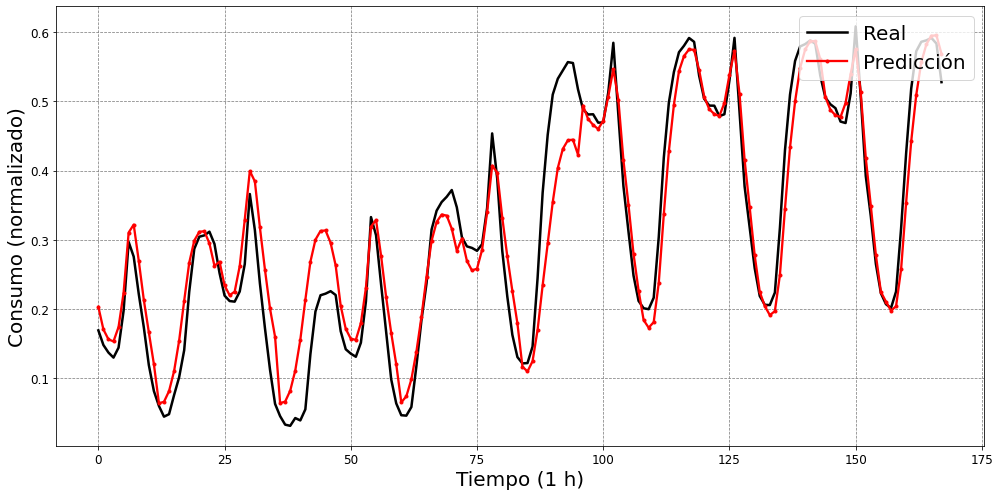

In [105]:
plot_hours(df_train_rfr.iloc[-1000:,:-12].to_numpy(), df_train_rfr.iloc[-1000:,-12:].to_numpy(),
           targets = 14, savefig = True, name = "rfr_final_12h_train")

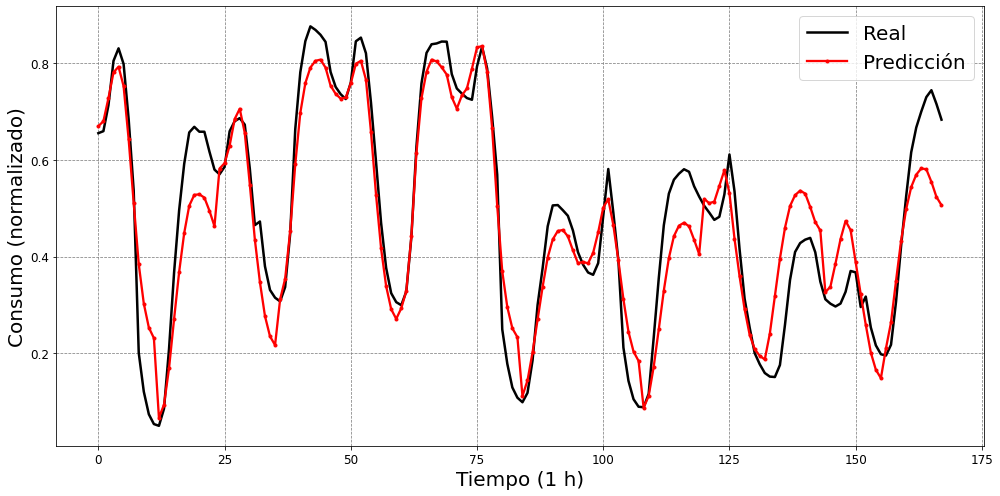

In [106]:
plot_hours(df_val_rfr.iloc[-1000:,:-12].to_numpy(), df_val_rfr.iloc[-1000:,-12:].to_numpy(),
           targets = 14, savefig = True, name = "rfr_final_12h_val")

In [ ]:
plot_hours(df_val_rfr.iloc[-1000:,:-12].to_numpy(), df_val_rfr.iloc[-1000:,-12:].to_numpy(),
           targets = 14, savefig = True, name = "rfr_final_12h_val")